In [1]:
import torch
import h5py
import os
import pandas as pd
from rich.progress import track

In [2]:
# Get the angular bin boundaries
n_bins = 360
angular_bin_boundaries = torch.arange(n_bins) / 180 * torch.pi

In [10]:
# load beams masks
# Define the layout index to load
layout_idx = 0

input_dir = "output"
# load the beams properties
beams_properties_hdf5_filename = (
    f"beams_properties_77faff53af5863ca146878c7c496c75e_{layout_idx:02d}.hdf5"
)
with h5py.File(
    os.path.join(input_dir, beams_properties_hdf5_filename), "r"
) as f:
    # print(f.keys())
    beams_properties_tensor = torch.from_numpy(f["beam_properties"][:])  # type: ignore
    beam_properties_header = f["beam_properties"].attrs["Header"]  # type: ignore

# load the beams masks for the layout
beams_masks_hdf5_filename = (
    f"beams_masks_77faff53af5863ca146878c7c496c75e_{layout_idx:02d}.hdf5"
)

with h5py.File(
    os.path.join(input_dir, beams_masks_hdf5_filename), "r"
) as beams_masks_hdf5:
    beams_masks = torch.from_numpy(beams_masks_hdf5["beam_mask"][:]) # type: ignore
layout_beams_properties = beams_properties_tensor.clone()
# Digitize the angles
digitized_angles = torch.bucketize(
    layout_beams_properties[:, 3], angular_bin_boundaries, right=False
)
layout_beams_properties= torch.cat(
    (
        layout_beams_properties,
        (digitized_angles-1).unsqueeze(1).float(),
    ),
    dim=1,
)
# layout_beams_properties[:, 3] = digitized_angles
# print(layout_beams_properties[:,3].max())

# columns_name: list = beam_properties_header.tolist()  # type: ignore
# columns_name[3] = "angle_bin"
# layout_beams_property_df = pd.DataFrame(
# 		layout_beams_properties.numpy(),
# 		columns=columns_name,  # type: ignore
# )


In [11]:
print(layout_beams_properties.shape)
print(layout_beams_properties[layout_beams_properties[:, -1] == 0, 3])

torch.Size([7072, 12])
tensor([0.0147, 0.0079, 0.0136, 0.0073, 0.0064, 0.0112, 0.0074, 0.0106, 0.0055,
        0.0064])


In [46]:
print(beam_properties_header.tolist())

['scanner position id', 'detector unit id', 'beam id', 'Angle (rad)', 'FWHM (mm)', 'weighted center x (mm)', 'weighted center y (mm)', 'sensitivity', 'relative sensitivity', 'number of pixels', 'number of coexisting beams']


In [47]:
layout_beams_properties = beams_properties_tensor.clone()
# Digitize the angles
digitized_angles = torch.bucketize(
    layout_beams_properties[:, 3], angular_bin_boundaries, right=False
)
layout_beams_properties= torch.cat(
    (
        layout_beams_properties,
        (digitized_angles-1).unsqueeze(1).float(),
    ),
    dim=1,
)

layout_beams_properties_filtered = layout_beams_properties[
    torch.isnan(layout_beams_properties[:, 3]) == False
]
layout_beams_properties_filtered = layout_beams_properties_filtered[
    layout_beams_properties_filtered[:, 4] < 4
]
beams_sensentivity_max = layout_beams_properties_filtered[:, 7].max()
layout_beams_properties_filtered = layout_beams_properties_filtered[
    layout_beams_properties_filtered[:, 7] > beams_sensentivity_max * 0.01]
print("Before filtering", layout_beams_properties.shape)
print("After filtering", layout_beams_properties_filtered.shape)

Before filtering torch.Size([7072, 12])
After filtering torch.Size([2813, 12])


In [48]:
# Initialize the histogram for ASCI map
asci_histogram = torch.zeros(
    (beams_masks.shape[1], n_bins),
    dtype=torch.int32,
)

# Loop through the beams, get the beam properties
for beam_props in track(layout_beams_properties_filtered, description="Processing beams"):
    detector_idx = int(beam_props[1])
    beam_idx = int(beam_props[2])
    angle_bin_idx = int(beam_props[11])
    asci_histogram[beams_masks[detector_idx] == beam_idx, angle_bin_idx] += 1

asci_map = torch.count_nonzero(asci_histogram, dim=1)/n_bins

Output()

In [17]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Y (mm)')

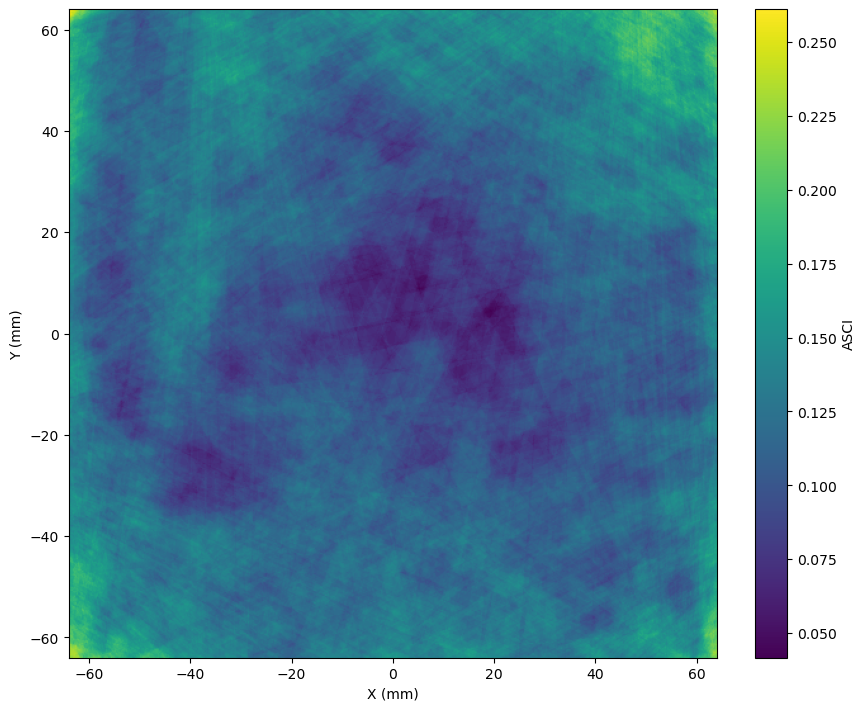

In [57]:
fig, ax = plt.subplots(figsize=(9, 7), layout="constrained")

cbar = fig.colorbar(ax.imshow(
    asci_map.view(512, 512).T, extent=(-64, 64, -64, 64), origin="lower", cmap="viridis", aspect="equal"
))
cbar.set_label("ASCI")
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")

In [1]:
## Loop through all layouts

# Initialize the histogram for ASCI map
asci_histogram = torch.zeros(
    (beams_masks.shape[1], n_bins),
    dtype=torch.int32,
)

for layout_idx in track(range(24), description="Processing layouts"):
    
    # load the beams properties
    beams_properties_hdf5_filename = (
        f"beams_properties_77faff53af5863ca146878c7c496c75e_{layout_idx:02d}.hdf5"
    )
    with h5py.File(os.path.join(input_dir, beams_properties_hdf5_filename), "r") as f:
        # print(f.keys())
        layout_beams_properties = torch.from_numpy(f["beam_properties"][:])  # type: ignore
        beam_properties_header = f["beam_properties"].attrs["Header"]  # type: ignore

    # load the beams masks for the layout
    beams_masks_hdf5_filename = (
        f"beams_masks_77faff53af5863ca146878c7c496c75e_{layout_idx:02d}.hdf5"
    )

    with h5py.File(
        os.path.join(input_dir, beams_masks_hdf5_filename), "r"
    ) as beams_masks_hdf5:
        beams_masks = torch.from_numpy(beams_masks_hdf5["beam_mask"][:])  # type: ignore

    # Digitize the angles
    digitized_angles = torch.bucketize(
        layout_beams_properties[:, 3], angular_bin_boundaries, right=False
    )
    layout_beams_properties = torch.cat(
        (
            layout_beams_properties,
            (digitized_angles - 1).unsqueeze(1).float(),
        ),
        dim=1,
    )

    # Digitize the angles
    digitized_angles = torch.bucketize(
        layout_beams_properties[:, 3], angular_bin_boundaries, right=False
    )
    layout_beams_properties = torch.cat(
        (
            layout_beams_properties,
            (digitized_angles - 1).unsqueeze(1).float(),
        ),
        dim=1,
    )

    layout_beams_properties_filtered = layout_beams_properties[
        torch.isnan(layout_beams_properties[:, 3]) == False
    ]
    layout_beams_properties_filtered = layout_beams_properties_filtered[
        layout_beams_properties_filtered[:, 4] < 4
    ]
    beams_sensentivity_max = layout_beams_properties_filtered[:, 7].max()
    layout_beams_properties_filtered = layout_beams_properties_filtered[
        layout_beams_properties_filtered[:, 7] > beams_sensentivity_max * 0.01
    ]

    # Loop through the beams, get the beam properties
    for beam_props in layout_beams_properties_filtered:
        detector_idx = int(beam_props[1])
        beam_idx = int(beam_props[2])
        angle_bin_idx = int(beam_props[11])
        asci_histogram[
            beams_masks[detector_idx] == beam_idx, angle_bin_idx
        ] += 1

NameError: name 'torch' is not defined

In [60]:
torch.save(
    asci_histogram,
    os.path.join(input_dir, "asci_histogram.tensor"),
)

In [ ]:
asci_histogram_sum = torch.sum(asci_histogram, dim=0)
print(asci_histogram_sum.shape)